# Kaggle Instacart Classification
This notebook contains the code for classifying whether or not an item will be in a user's most recent cart in the Kaggle Instacart Contest dataset. Most of the functionality (SQL queries, feature engineering, and model training) lives in **build_models.py**, which can be run through a notebook or the command line. If the script is run on a cloud instance, the contents of the cloud **data** directory can be copied into the local version in order to be loaded by this notebook.

### Table of Contents
* [1. Imports and Functions](#sec1)
* [2. Train Models or Load Models From Files](#sec2)
* [3. Feature Engineering](#sec3)
* [4. Function for Probability Threshold Adjustment](#sec4)
* [5. Per-Item Model Evaluation](#sec5)
* [6. Mean Per-User Model Evaluation](#sec6)
* [7. Finding the Most Influential Features](#sec7)
* [8. Histograms of User F1 Scores](#sec8)

<a id='sec1'></a>
### 1. Imports and Functions
* **build_models**: Queries SQL database, engineers features, and trains models
* **read_pickle**: Reads the given pickle file

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('./code')
import build_models as bm
from lw_pickle import read_pickle

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id='sec2'></a>
### 2. Train Models or Load Models From Files
I offloaded SQL queries, feature engineering, and model training to the **build_models.py** script in the **code** directory. The script saves a dataframe of testing set data called **test_df** into a .csv file and the logistic regression and gradient boosting decision tree models, **lrm** and **gbm** respectively, into pickle files. All test set and model data is stored in the **data** directory and if they exist, they will be loaded by this notebook. If they do not exist, the notebook trains models for a limited subset of the data (1,000 users) to ensure that the process does not overtax system resources. For final model evaluation, I trained models on the entire dataset of 13,120 users using an AWS EC2 instance and copied the resulting files over to the local **data** directory. My computer had enough RAM to train on 5,000 users in under 10 minutes, but could not handle the full dataset. The 2xLarge EC2 instance took **1 hour and 47 minutes** to train models on the full dataset. Due to file size restrictions only part of the test set used in this notebook is on Github.

In [2]:
# Setting force_rebuild to True will result in a local re-run of the
# model build script regardless of whether or not local data exists
force_rebuild = False
test_df_csv = 'data/test_df.csv'
model_lrm_pickle = 'data/model_lrm.pk'
model_gbm_pickle = 'data/model_gbm.pk'

# Attempts to load test set and models from local files
test_df = pd.read_csv(test_df_csv, index_col=0)
lrm = read_pickle(model_lrm_pickle)
gbm = read_pickle(model_gbm_pickle)

# Runs build_models script if test set or models did not load
pk_types = [type(x) for x in [test_df, lrm, gbm]]
if type(None) in pk_types or force_rebuild:
    data = bm.build_models(user_limit=1000)
    test_df = data.test_df
    lrm = data.lrm
    gbm = data.gbm
    
# Gets relevant Dataframe columns from build_models
id_col = bm.build_models.id_col
y_col = bm.build_models.y_col
x_cols = bm.build_models.x_cols

<a id='sec3'></a>
### 3. Feature Engineering
All of these features are created in the last step through the **build_models.py** script and used to train both models:
* **percent_in_user_orders**: Percent of a user's orders in which an item appears
* **percent_in_all_orders**: Percent of all orders in which an item appears
* **in_last_cart**: 1 if an item appears in a user's most recent prior order, 0 if not
* **in_last_five**: Number of orders in a user's five most recent prior orders in which an item appears
* **total_user_orders**: Total number of orders placed by a user
* **mean_orders_between**: Average number of orders between which an item appears in a user's order
* **mean_days_between**: Average number of days between which an item appears in a user's order
* **orders_since_newest**: Number of orders between the last user order containing an item and the most recent order
* **days_since_newest**: Number of days between the last user order containing an item and the most recent order
* **product_reorder_proba**: Probability that any user reorders an item
* **user_reorder_proba**: Probability that a user reorders any item
* **mean_cart_size**: Average user cart (aka order) size
* **mean_cart_percentile**: Average percentile of user cart add order for an item
* **mean_hour_of_week**: Average hour of the week that a user orders an item (168 hours in a week)
* **newest_cart_size**: Number of items in the most recent cart
* **newest_hour_of_week**: Hour of the week that the most recent order was placed
* **cart_size_difference**: Absolute value of the difference between the average size of the orders containing an item and the size of the most recent order
* **hour_of_week_difference**: Absolute value of the difference between the average hour of the week in which a user purchases an item and the hour of the week of the most recent order

<a id='sec4'></a>
### 4. Function for Probability Threshold Adjustment
In order to account for the class imbalance that results from most items in a user's order history not being in their current cart, I adjust the probability threshold separating the two classes.

In [3]:
def adjust_threshold(proba, threshold=.5):
    return (proba[:, 1] >= threshold).astype(int)

<a id='sec5'></a>
### 5. Per-Item Model Evaluation
I calculated F1 scores for both the logistic regression and gradient boosting decision tree models treating each item in a user's order history with equal weight. I chose F1 to balance precision and recall and adjusted the probability threshold to maximize F1 scores for each model.

In [4]:
# Calculates logistic regression F1 score using base .5 probability threshold
lrm_proba = lrm.predict_proba(test_df[x_cols])
lrm_pred = adjust_threshold(lrm_proba)
lrm_base_f1 = round(f1_score(test_df[y_col], lrm_pred), 3)

# Calculates logistic regression F1 score using optimized probability threshold
lrm_th = .17
lrm_adj = adjust_threshold(lrm_proba, lrm_th)
lrm_opt_f1 = round(f1_score(test_df[y_col], lrm_adj), 3)

print('Logistic Regression:')
print(f'F1 Score @ 0.50 prob. threshold: {lrm_base_f1}')
print(f'F1 Score @ {lrm_th} prob. threshold: {lrm_opt_f1}')

Logistic Regression:
F1 Score @ 0.50 prob. threshold: 0.313
F1 Score @ 0.17 prob. threshold: 0.447


In [5]:
# Calculates gradient boosting trees F1 score using base .5 probability threshold
gbm_proba = gbm.predict_proba(test_df[x_cols])
gbm_pred = adjust_threshold(gbm_proba)
gbm_base_f1 = round(f1_score(test_df[y_col], gbm_pred), 3)

# Calculates gradient boosting trees F1 score using optimized probability threshold
gbm_th = .21
gbm_adj = adjust_threshold(gbm_proba, gbm_th)
gbm_opt_f1 = round(f1_score(test_df[y_col], gbm_adj), 3)

print('Gradient Boosting Decision Trees:')
print(f'F1 Score @ 0.50 prob. threshold: {gbm_base_f1}')
print(f'F1 Score @ {gbm_th} prob. threshold: {gbm_opt_f1}')

Gradient Boosting Decision Trees:
F1 Score @ 0.50 prob. threshold: 0.338
F1 Score @ 0.21 prob. threshold: 0.461


<a id='sec6'></a>
### 6. Mean Per-User Model Evaluation
I created a separate metric to better evaluate how the models perform for the average user. If either model were incorporated into a recommendation engine the user-based metric would better represent its performance.

In [6]:
lrm_adj = adjust_threshold(lrm_proba, .16)
gbm_adj = adjust_threshold(gbm_proba, .17)

score_df = test_df[[id_col, y_col]].reset_index(drop=True)
score_df['lrm'] = lrm_adj
score_df['gbm'] = gbm_adj
users = score_df[id_col].unique()

lrm_f1 = []
gbm_f1 = []
for user in users:
    user_df = score_df[score_df[id_col] == user]
    lrm_f1.append(f1_score(user_df[y_col], user_df['lrm']))
    gbm_f1.append(f1_score(user_df[y_col], user_df['gbm']))
mean_lrm_f1 = round(np.mean(lrm_f1), 3)
mean_gbm_f1 = round(np.mean(gbm_f1), 3)

print('Per-User Optimized F1 Scores:')
print(f'Linear Regression: {mean_lrm_f1}')
print(f'Gradient Boosting Decision Trees: {mean_gbm_f1}')

Per-User Optimized F1 Scores:
Linear Regression: 0.367
Gradient Boosting Decision Trees: 0.368


<a id='sec7'></a>
### 7. Finding the Most Influential Features
I charted the feature coefficients for both models to see which predictors most influence the models. The logistic regression model relies heavily upon information about the size of the most recent cart, while the gradient boosting decision trees model gives far more weight to the contents of a user's previous orders. If information about the most recent cart were not available, the gradient boosting model would most likely outperform the logistic regression model.

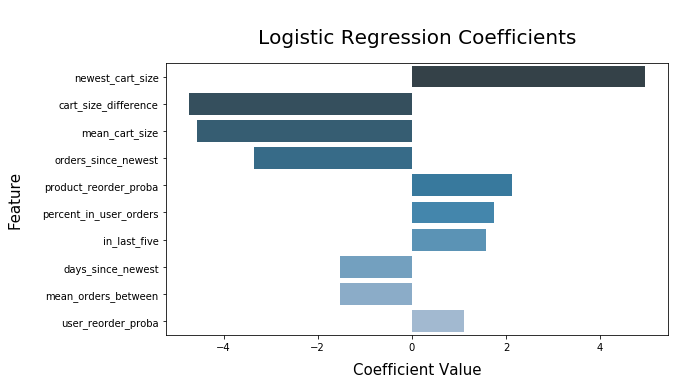

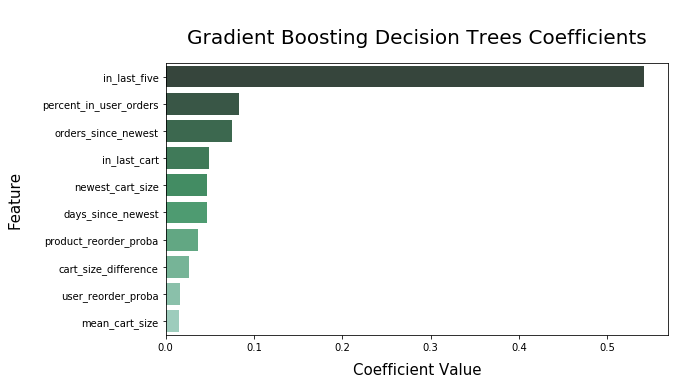

In [7]:
feature_df = pd.DataFrame({'feature': x_cols,
                           'lrm_coef': lrm.coef_[0].tolist(),
                           'lrm_abs_coef': np.abs(lrm.coef_[0]).tolist(),
                           'xgb_coef': gbm.feature_importances_.tolist()})

sort_df = feature_df.sort_values('lrm_abs_coef', ascending=False)[:10]
plt.figure(figsize=(9, 5))
plt.margins(y=100)
plt.title('\nLogistic Regression Coefficients', size=20, y=1.05)
sns.barplot(x=sort_df['lrm_coef'], y=sort_df['feature'], palette='PuBu_d')
plt.xlabel('Coefficient Value', size=15, labelpad=10)
plt.ylabel('Feature', size=15, labelpad=20)

sort_df = feature_df.sort_values('xgb_coef', ascending=False)[:10]
plt.figure(figsize=(9, 5))
plt.title('\nGradient Boosting Decision Trees Coefficients', size=20, y=1.05)
sns.barplot(x=sort_df['xgb_coef'], y=sort_df['feature'], palette='BuGn_d')
plt.xlabel('Coefficient Value', size=15, labelpad=10)
plt.ylabel('Feature', size=15, labelpad=20);

<a id='sec8'></a>
### 8. Histograms of User F1 Scores

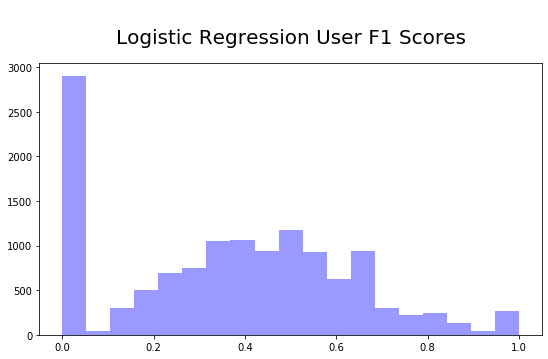

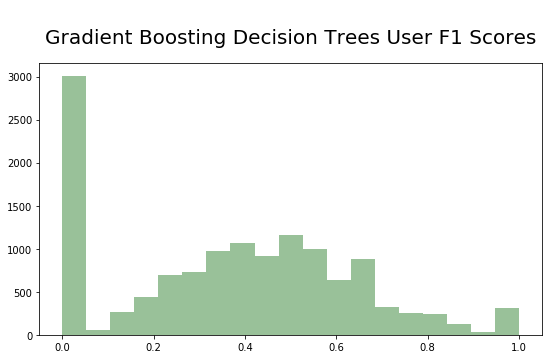

In [8]:
plt.figure(figsize=(9, 5))
plt.title('\nLogistic Regression User F1 Scores', size=20, y=1.05)
sns.distplot(lrm_f1, bins=np.linspace(0, 1, 20), kde=False, color='blue');

plt.figure(figsize=(9, 5))
plt.title('\nGradient Boosting Decision Trees User F1 Scores', size=20, y=1.05)
sns.distplot(gbm_f1, bins=np.linspace(0, 1, 20), kde=False, color='darkgreen');